In [1]:
import os
import string
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from difflib import SequenceMatcher
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from statistics import mean

import gensim
from gensim.models.doc2vec import Doc2Vec
from sentence_transformers import SentenceTransformer

import tensorflow as tf
import tensorflow_hub as hub


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt')

stop_words = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nishq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nishq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nishq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nishq\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nishq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
all_lines = []
directory = 'factiva_articles/'
for file in os.listdir(directory):
    
    f = open(directory + file, "r")
    lines = f.readlines()
    
    all_lines.extend(lines)
    

# Extracting individual articles from the entire corpus
total_article_count = 0
articles_used = 0

# Temporary string for storing each article
temp_string = """"""

# List of all articles
all_articles = []

# Temporary list that stores each article as separate lines in order to determine the article's line count
temp_lines = []


for line in all_lines:
    
    # "Document " followed by a code signals the end of an article
    if 'Document ' in line: 
        
        total_article_count += 1
        # If this article's line count is greater than 10, only then save it
        if len(temp_lines) > 10:
            
            # Keeping count of the number of articles used
            articles_used += 1
            
            #print(len(temp_lines))
            all_articles.append(temp_string)
            
        # Reset temp variables
        temp_lines = []
        temp_string = """"""
    
    # Keep updating temp variables
    else:
        temp_string += line
        temp_lines.append(line)
        
# Print count of articles        
print(total_article_count)
print(articles_used)


# Sanity check and removing unnecessary information from articles
sanitized_article_count = 0
all_articles_sanitized = []

for article in all_articles:
    
    # Get the first double line break index after the initial line breaks (starting after index 10)
    start_index = article.index("\n\n", 10)
    # Get the next double line break that's the start_index + 4 (4 characters - \n\n)
    end_index = article.index("\n\n", start_index + 4)
    
    # Sanity_check to make sure we're removing the correct information and not important information in the article
    if '504' in article[start_index:end_index]:
        sanitized_article_count += 1
    else: 
        print(start_index)
        print(end_index)
        print(article[start_index:end_index])
        #print(article)
        
    # Create new string that removes this substring from start_index to end_index
    new_article = article[0 : start_index : ] + article[end_index + 1 : :]
    
    # Replace all new lines with spaces
    new_article = new_article.replace('\n', ' ')
    
    new_article = new_article.strip(" ")
    
    # Add this article to list of sanitized articles
    all_articles_sanitized.append(new_article)
    
print(sanitized_article_count)


# Loading financial wellbeing df
finance_df = pd.read_excel("Fin_Wellbeing_subsample.xlsx")
finance_df = finance_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Matching article titles from financial wellbeing excelsheet to articles in sanitized articles list
title_found = False
article_found_count = 0

article_dicts = [] 
for article_title in finance_df['article_title']:
    
    article_title = article_title.strip(" ")
    article_title_list = article_title.split(" ")
    title_first_word = article_title_list[0]   
    title_found = False
    print("")
    print("-------------------------------NEW ARTICLE----------------------------------------")
    print("Article title: "+article_title)
    
    
    for article in all_articles_sanitized:
        
        article_list = article.split(" ")
        
        first_word_found_before = False
        for word in article_list[0:30]:
            
            if title_found == True:
                break
                
            first_word_similarity = similar(title_first_word, word)
            
            if first_word_similarity > 0.9:
                
                print(f"FIRST WORD MATCH FOUND: {title_first_word}, {word}, {first_word_similarity}")
                #print(title_first_word, word, first_word_similarity)
                
                if first_word_found_before == False:
                    start_index = article.index(word)
                    
                else:
                    start_index = article[start_index+len(word):].index(word)
                
                title_similarity = similar(article_title, article[start_index:start_index + len(article_title)])
                print("Sentence:       "+ article[start_index:start_index + len(article_title)])
                print("Sentence Similarity: " +str(title_similarity))
                
                first_word_found_before = True
                if title_similarity > 0.9:
                    title_found = True
                    article_found_count += 1
                    new_dict = {}
                    
                    new_dict["article_title"] = article_title
                    new_dict["text"] = article
                    #print(finance_df[finance_df["article_title"] == article_title]["relevant_campbell"])
                    new_dict["relevant_campbell"] = finance_df[finance_df["article_title"] == article_title]["relevant_campbell"].values[0]
                    new_dict["relevant_kristen"] = finance_df[finance_df["article_title"] == article_title]["relevant_kristen"].values[0]
                    new_dict["mismatch"] = finance_df[finance_df["article_title"] == article_title]["mismatch"].values[0]
                    
                    article_dicts.append(new_dict)
                    break
                    
                else:
                    title_found = False
                    
            else:
                title_found = False
            
    print("-----------------------------------------------------------------------------------")
    
print(article_found_count)

# Creating a new df with article titles, article text and classifications
articles_df = pd.DataFrame(article_dicts)

# sanity check to ensure all the matched values for classifications by campbell and kristen across both dataframes match
for article_title in articles_df["article_title"]:
    if finance_df[finance_df["article_title"] == article_title]["relevant_campbell"].values[0] != articles_df[articles_df["article_title"] == article_title]["relevant_campbell"].values[0]:
        print("Error in relevant_campbell")
        print(article_title)
        print(finance_df[finance_df["article_title"] == article_title]["relevant_campbell"].values[0])
        print(articles_df[articles_df["article_title"] == article_title]["relevant_campbell"].values[0])

    if finance_df[finance_df["article_title"] == article_title]["relevant_kristen"].values[0] != articles_df[articles_df["article_title"] == article_title]["relevant_kristen"].values[0]:
        print("Error in relevant_kristen")
        print(article_title)
        print(finance_df[finance_df["article_title"] == article_title]["relevant_kristen"].values[0])
        print(articles_df[articles_df["article_title"] == article_title]["relevant_kristen"].values[0])

    if finance_df[finance_df["article_title"] == article_title]["mismatch"].values[0] != articles_df[articles_df["article_title"] == article_title]["mismatch"].values[0]:
        print("Error in mismatch")
        print(article_title)
        print(finance_df[finance_df["article_title"] == article_title]["mismatch"].values[0])
        print(articles_df[articles_df["article_title"] == article_title]["mismatch"].values[0])

        

1388
1366
134
279


NEW YORK, April 10, 2019 /PRNewswire/ -- ERISA wrap document provider, Clarity Benefit Solutions, discusses the importance of ERISA compliance.
182
583


RICH KAPELKE SPOKANE DRIVERS IGNORING RULES I feel that many will attest to studying the driver's manual to obtain their licenses, and afterward ignoring the basic rules of the road once they have license in hand.In adverse weather conditions and during either dusk or dawn, no driver has headlights on.The proponents of the program should form a health care company and sell one product, Obamacare.
172
547


David Tiller, Head of Adviser Propositions and Strategy at Standard Life, said: "We really have entered the golden age for advisers who now have the opportunity to provide more of the population with advice when they need it most. This need has never been greater and it is vitally important the industry works together to ensure that people can access the help they need."
129
321


IT'S really to draw attention to

-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Couple who bought B&Q plant for just £12 discover its leaves are worth £170 each
FIRST WORD MATCH FOUND: Couple, Couple, 1.0
Sentence:       Couple who bought B&Q plant for just £12 discover its leaves are worth £170 each
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Drivers face £35bn tax bill to plug the gap as switch to electric cars hits revenue
FIRST WORD MATCH FOUND: Drivers, Drivers, 1.0
Sentence:       Drivers face £35bn tax bill to plug the gap as switch to electric cars hits revenue
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE-----

-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: SCAM ALERT: LOAN REPAYMENT COMPANIES SCAMMING STUDENTS, CHARGING THEM FOR SERVICES AVAILABLE FOR FREE
FIRST WORD MATCH FOUND: SCAM, SCAM, 1.0
Sentence:       SCAM ALERT: LOAN REPAYMENT COMPANIES SCAMMING STUDENTS, CHARGING THEM FOR SERVICES AVAILABLE FOR FREE
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: State Pension age changes could affect when you will be able to retire - check yours now
FIRST WORD MATCH FOUND: State, State, 1.0
Sentence:       State College ; St Joseph, MO - news  By  (The Center Square) - President Joe Biden tout
Sentence Similarity: 0.2727272727272727
FIRST WORD MATCH FOUND: State, States, 0.9090909090909091
Sentence:      

FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More Than Expected In October Primarily reflecting a bounce back in the South after hurricane-related disruptions in the previous month, 
Sentence Similarity: 0.26277372262773724
FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More A Coupon website adding thousands of new discount coupons every week  Don'tPayAll, an enormously popular coupon code website, is con
Sentence Similarity: 0.32116788321167883
FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More than three people in four will be seeing in 2017 at home - either quietly or surrounded by friends - but this could quickly turn int
Sentence Similarity: 0.2773722627737226
FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More than half a billion pounds are being handed over every year in inheritance tax from life insurance policies because people aren't pl
Sentence Similarity: 0.29927007299270075
FIRST WORD MATCH FOUND: More, More, 1.0
Sentence:       More 

FIRST WORD MATCH FOUND: What, What, 1.0
Sentence:       What cinemas will look like after lockdown -with special areas for social bubbles
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Review: Banks took $11B in overdraft fees in 2019; Vulnerable people hit hardest, Center for Responsible Lending says
FIRST WORD MATCH FOUND: Review:, Review, 0.9230769230769231
Sentence:       Review due diligence against your new documented proposition to ensure your business model for clients exercising ret
Sentence Similarity: 0.2905982905982906
FIRST WORD MATCH FOUND: Review:, Review, 0.9230769230769231
Sentence:       Review Personal Finance 2011 BMW 335d; Proving that even a diesel system can be a pleasure to drive DAMASCUS, Md. (Ma
Sentence Similarity: 0.21367521367521367
FIRST WORD MATCH FOUND: Review:, Review, 0.9230769230769231
Sentenc

FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The first offers are no
Sentence Similarity: 0.391304347826087
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The company, which had 
Sentence Similarity: 0.34782608695652173
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The government should p
Sentence Similarity: 0.2608695652173913
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The most sought after o
Sentence Similarity: 0.34782608695652173
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Island Suspected ki
Sentence Similarity: 0.34782608695652173
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       t' The father of one of
Sentence Similarity: 0.391304347826087
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Centre for Social J
Sentence Similarity: 0.30434782608695654
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Radcliff, Founded o
Sentence Similarity: 0.43478260869565216
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:      

Sentence Similarity: 0.30434782608695654
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The breathtaking announ
Sentence Similarity: 0.2608695652173913
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The default rate of "sl
Sentence Similarity: 0.5652173913043478
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The pressure on family 
Sentence Similarity: 0.43478260869565216
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The two-week government
Sentence Similarity: 0.391304347826087
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The private equity back
Sentence Similarity: 0.391304347826087
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Latest Getaway Holi
Sentence Similarity: 0.34782608695652173
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The impact of divorce o
Sentence Similarity: 0.43478260869565216
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The booking cost was di
Sentence Similarity: 0.2608695652173913
FIRST WORD MAT

-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Advice fees vary by 1,000 per cent
FIRST WORD MATCH FOUND: Advice, Advice, 1.0
Sentence:       Advice column: Mortgage Advice Bur
Sentence Similarity: 0.35294117647058826
FIRST WORD MATCH FOUND: Advice, Advice, 1.0
Sentence:       vice column: Mortgage Advice Burea
Sentence Similarity: 0.2647058823529412
FIRST WORD MATCH FOUND: Advice, Advice, 1.0
Sentence:       Advice column: Mortgage Advice Bur
Sentence Similarity: 0.35294117647058826
FIRST WORD MATCH FOUND: Advice, Advice, 1.0
Sentence:       Advice fees vary by 1,000 per cent
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Tapping into 529 account; Grandfather can reimburse student's parents fo

FIRST WORD MATCH FOUND: SMART, SMART, 1.0
Sentence:       SMART Note      504 words 3 April 2006
Sentence Similarity: 0.3684210526315789
FIRST WORD MATCH FOUND: SMART, SMART, 1.0
Sentence:       SMART FUNDS  A five-year performance c
Sentence Similarity: 0.3157894736842105
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Anne Meiring, Anthony Clarizio and Sheri Kittelson: Don't wait to make end-of-life plans
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Kiplinger's Personal Finance: How to trim your car, home and health insurance premiums
FIRST WORD MATCH FOUND: Kiplinger's, Kiplinger's, 1.0
Sentence:       Kiplinger's latest forecast on interest rates..article ul.kip-eo-mlinks { color: #ccc;
Sentence Similarity: 0.3255

FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Zealand) APNTDP A08 Englis
Sentence Similarity: 0.23333333333333334
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New life span data threaten pe
Sentence Similarity: 0.4666666666666667
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New VCT rules scare investors 
Sentence Similarity: 0.3
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New York City offers its emplo
Sentence Similarity: 0.3333333333333333
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New official report reveals th
Sentence Similarity: 0.3333333333333333
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New York Culture Couple's Trus
Sentence Similarity: 0.4666666666666667
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       oy New York City's cultural sm
Sentence Similarity: 0.26666666666666666
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Book by Chicago Tax and Es
Sentence Similarity: 0.23333333333333334
FIRST WORD M

-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: 'eBay fraudster stole £1,023 and my gold coins but PayPal won't refund me'
FIRST WORD MATCH FOUND: 'eBay, 'eBay, 1.0
Sentence:       'eBay fraudster stole £1,023 and my gold coins but PayPal won't refund me'
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Draw up your will in a text message
FIRST WORD MATCH FOUND: Draw, Draw, 1.0
Sentence:       Draw up your will in a text message
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Pension fund moves into riskier investments; Venture Capital
FIRS

FIRST WORD MATCH FOUND: Getting, Getting, 1.0
Sentence:       Getting a thorough home inspecti
Sentence Similarity: 0.5
FIRST WORD MATCH FOUND: Getting, Getting, 1.0
Sentence:       Getting a loan is all about risk
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Warning on rate hikes
FIRST WORD MATCH FOUND: Warning, Warning, 1.0
Sentence:       Warning on rate hikes
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Bank of England tightens mortgage borrowing rules amid fears of debt boom
FIRST WORD MATCH FOUND: Bank, Bank, 1.0
Sentence:       Bank of England's extraordinary intervention in the UK Government bond ma
Sentence Similarity: 0.3424657534246575
FIRST WORD MATCH FO

FIRST WORD MATCH FOUND: Australia, Australian, 0.9473684210526315
Sentence:       Australian share prices have soared to record highs over the past year,
Sentence Similarity: 0.4225352112676056
FIRST WORD MATCH FOUND: Australia, Australian, 0.9473684210526315
Sentence:       Australian workers has been splashing out on lavish sponsorship and cor
Sentence Similarity: 0.39436619718309857
FIRST WORD MATCH FOUND: Australia, Australian, 0.9473684210526315
Sentence:       Australian travellers are being challenged to rethink their attitudes t
Sentence Similarity: 0.36619718309859156
FIRST WORD MATCH FOUND: Australia, Australian, 0.9473684210526315
Sentence:       Australian workers will dramatically outlive their superannuation savin
Sentence Similarity: 0.4084507042253521
FIRST WORD MATCH FOUND: Australia, Australia:, 0.9473684210526315
Sentence:       Australia: Joanne Martin Owns Trademark for 'OWN YOUR ROAD' and 'WOMAN,
Sentence Similarity: 0.30985915492957744
FIRST WORD MATCH FOUND: Aus

FIRST WORD MATCH FOUND: Long-term, Long-term, 1.0
Sentence:       Long-term care delay post-fire frustrates seniors
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Shelby County trustee says property tax collections up, but delinquent tax collections are concerning
FIRST WORD MATCH FOUND: Shelby, Shelby, 1.0
Sentence:       Shelby County on Tuesday soundly rejected a proposal to increase the county sales tax by a half-cent.
Sentence Similarity: 0.3564356435643564
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Keys to keeping lid on spending
FIRST WORD MATCH FOUND: Keys, Keys, 1.0
Sentence:       Keys to keeping lid on spending
Sentence Similarity: 1.0
--------------------------------------------

FIRST WORD MATCH FOUND: COURT, COURT, 1.0
Sentence:       COURT ISSUES ORDER REGARDING DAVID BALLINGA
Sentence Similarity: 0.27906976744186046
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Decide if a living trust is right for your estate
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Health Care on a Budget
FIRST WORD MATCH FOUND: Health, Health, 1.0
Sentence:       Health Insurance with C
Sentence Similarity: 0.4782608695652174
FIRST WORD MATCH FOUND: Health, Health;, 0.9230769230769231
Sentence:       200,000 Coloradans Enro
Sentence Similarity: 0.21739130434782608
FIRST WORD MATCH FOUND: Health, Health, 1.0
Sentence:        200,000 Coloradans Enr
Sentence Similarity: 0.17391304347826086
FIRST WORD MATCH FOUND: Hea

FIRST WORD MATCH FOUND: How, How, 1.0
Sentence:       How some Georgia businesses are reopening and if you're skipping your mortgage payments, watch out for
Sentence Similarity: 0.2647058823529412
FIRST WORD MATCH FOUND: How, How, 1.0
Sentence:       How to Protect Yourself From Financial Fraud Bowling Green State University ; Bolwing Green, OH - news
Sentence Similarity: 0.2647058823529412
FIRST WORD MATCH FOUND: How, How, 1.0
Sentence:       How family with pre-existing medical conditions found incredible travel insurance cover to go on dream
Sentence Similarity: 0.27450980392156865
FIRST WORD MATCH FOUND: How, How, 1.0
Sentence:       How savers are using the Lifetime Isa Seven out of 10 One Family Lifetime Isa customers are saving for
Sentence Similarity: 0.20588235294117646
FIRST WORD MATCH FOUND: How, How, 1.0
Sentence:       How to save on your household bills There are savings to be made within the four walls of your home - 
Sentence Similarity: 0.3137254901960784
FIRST WORD MA

FIRST WORD MATCH FOUND: Student, Student, 1.0
Sentence:       Student Lending Conference, Nov. 7-9, who feared a Kerry win woul
Sentence Similarity: 0.3384615384615385
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Social Security and You ; Social Security can help in child health crisis
FIRST WORD MATCH FOUND: Social, Social, 1.0
Sentence:       Social Security Act; Bipartisan Bill Helps American Workers Plan for Reti
Sentence Similarity: 0.4657534246575342
FIRST WORD MATCH FOUND: Social, Social, 1.0
Sentence:       Social Justice is calling for the state pension age to be raised to 70 by
Sentence Similarity: 0.2876712328767123
FIRST WORD MATCH FOUND: Social, Social, 1.0
Sentence:       Social Security; Sen. Sanders, Bernard (I - VT) News Release WASHINGTON, 
Sentence Similarity: 0.410958904109589
FIRST WORD MATCH FOUND: Social, Social, 1.0
Sentence: 

FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Discount Coupon On New Jacvapour Series E Best E Cigarette UK has published new information on a special discount ava
Sentence Similarity: 0.09090909090909091
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       Releases New Discount Coupon On New Jacvapour Series E Best E Cigarette UK has published new information on a special dis
Sentence Similarity: 0.09090909090909091
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Delhi, Jan 11 (PTI) Stringent compliance requirements under the Foreign Account Tax Compliance Act of the US have led
Sentence Similarity: 0.30578512396694213
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       News New report reveals older worker hotspots and the vast differences in employment prospects for over 50s around the co
Sentence Similarity: 0.9586776859504132
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE------

FIRST WORD MATCH FOUND: Charge, Charge, 1.0
Sentence:       Charge investors higher rate
Sentence Similarity: 0.42857142857142855
FIRST WORD MATCH FOUND: Charge, Charges, 0.9230769230769231
Sentence:       Charges Financial Advisor wi
Sentence Similarity: 0.42857142857142855
FIRST WORD MATCH FOUND: Charge, Charge, 1.0
Sentence:       Charge Cards vs. Debit Cards
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: New house sales build
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New petition calls fo
Sentence Similarity: 0.47619047619047616
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Financial Behavio
Sentence Similarity: 0.38095238095238093
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New York, a live even
Sentence Similarity: 0.38095238095238093
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       

FIRST WORD MATCH FOUND: Why, Why, 1.0
Sentence:       Why the LaGuardia delays may have played a special role in ending the shutdown; Hell hath no fury like a grounded passenger 
Sentence Similarity: 0.20161290322580644
FIRST WORD MATCH FOUND: Why, Why, 1.0
Sentence:       Why Families Need an Estate Plan  Kansas estate planning attorney Philip Wright, of Wright Law Firm, LC, lists the top three
Sentence Similarity: 0.1935483870967742
FIRST WORD MATCH FOUND: Why, Why, 1.0
Sentence:       Why raiding pensions is a bad idea Robert Graves  Talking head Pensions tax Speculation is rising that the Treasury will att
Sentence Similarity: 0.4032258064516129
FIRST WORD MATCH FOUND: Why, Why, 1.0
Sentence:       Why Fed's huge US$5.4T balance sheet could steer rate-hike policy The normalization of U.S. Federal Reserve policy is suppos
Sentence Similarity: 0.2903225806451613
FIRST WORD MATCH FOUND: Why, Why, 1.0
Sentence:       Why go?  Sunshine and surf are the island's two biggest commodities, 

FIRST WORD MATCH FOUND: A, A, 1.0
Sentence:       A majority of
Sentence Similarity: 0.38461538461538464
FIRST WORD MATCH FOUND: A, A, 1.0
Sentence:       A fund of one
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Compulsory pension for West workers
FIRST WORD MATCH FOUND: Compulsory, Compulsory, 1.0
Sentence:       Compulsory pension for West workers
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Three Tips For Building A Lasting Retirement
FIRST WORD MATCH FOUND: Three, Three, 1.0
Sentence:       Three fifths (61%) say they have had to scra
Sentence Similarity: 0.2727272727272727
FIRST WORD MATCH FOUND: Three, Three, 1.0
Sentence:       Three Tips For Building A Las

-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Grown-Up Spring Break Spots
FIRST WORD MATCH FOUND: Grown-Up, Grown-Up, 1.0
Sentence:       Grown-Up Spring Break Spots
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Should I use lump sum to pay off mortgage or save for children's studies?
FIRST WORD MATCH FOUND: Should, Should, 1.0
Sentence:       Should Be Allowed to Consider Climate Change, Other ESG Factors in Invest
Sentence Similarity: 0.3424657534246575
FIRST WORD MATCH FOUND: Should, Should, 1.0
Sentence:       Should Indian investors consider US stock market investment from India? I
Sentence Similarity: 0.3150684931506849
FIRST WORD MATCH FOUND: Should, Should, 1.0
Sentence:       Should 

FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Discount Coupon On New Jacvapour Series E Best E Cigarette UK has published new information on a special discount available for the newly
Sentence Similarity: 0.2198581560283688
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       Releases New Discount Coupon On New Jacvapour Series E Best E Cigarette UK has published new information on a special discount available for 
Sentence Similarity: 0.2127659574468085
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       New Delhi, Jan 11 (PTI) Stringent compliance requirements under the Foreign Account Tax Compliance Act of the US have led to several mutual f
Sentence Similarity: 0.23404255319148937
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       News New report reveals older worker hotspots and the vast differences in employment prospects for over 50s around the country Watford, Dorse
Sentence Similarity: 0.19858156028368795
FIRST WORD MATCH FOUND: New, New, 1.0
Sentence:       

FIRST WORD MATCH FOUND: YOUR, YOUR, 1.0
Sentence:       YOUR MONEY: Diversified as
Sentence Similarity: 0.46153846153846156
FIRST WORD MATCH FOUND: YOUR, YOUR, 1.0
Sentence:       YOUR MONEY-Best 401(k) pla
Sentence Similarity: 0.46153846153846156
FIRST WORD MATCH FOUND: YOUR, YOUR, 1.0
Sentence:       YOUR money: TAKE YOUR DIGI
Sentence Similarity: 0.34615384615384615
FIRST WORD MATCH FOUND: YOUR, YOUR, 1.0
Sentence:       ey: TAKE YOUR DIGITAL PIC 
Sentence Similarity: 0.3076923076923077
FIRST WORD MATCH FOUND: YOUR, YOUR, 1.0
Sentence:       YOUR MONEY  Teepee firm ha
Sentence Similarity: 0.5
FIRST WORD MATCH FOUND: YOUR, YOUR, 1.0
Sentence:       YOUR MONEY BORROWING WATCH
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Cloud of debt lifted through financial coaching program
FIRST WORD MATCH FOUND: Cloud, Cloud, 1.0
Sentence

FIRST WORD MATCH FOUND: Don't, Don't, 1.0
Sentence:       Don't be afraid t
Sentence Similarity: 0.5882352941176471
FIRST WORD MATCH FOUND: Don't, Don't, 1.0
Sentence:       Don't accept your
Sentence Similarity: 0.5294117647058824
FIRST WORD MATCH FOUND: Don't, Don't, 1.0
Sentence:       Don't be too late
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Consolidation loans - not the easy way out
FIRST WORD MATCH FOUND: Consolidation, Consolidation, 1.0
Sentence:       Consolidation loans - not the easy way out
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Mortgage squeeze tightens after Abbey clamps down on interest-only deals
FIRST WORD MATCH FOUND: Mortgage, Mortgages

FIRST WORD MATCH FOUND: Saving, Savings, 0.9230769230769231
Sentence:       Savings Rate cuts put sav
Sentence Similarity: 0.48
FIRST WORD MATCH FOUND: Saving, Savings, 0.9230769230769231
Sentence:       Savings Rate cuts put sav
Sentence Similarity: 0.48
FIRST WORD MATCH FOUND: Saving, Savings, 0.9230769230769231
Sentence:       Savings accounts have lon
Sentence Similarity: 0.44
FIRST WORD MATCH FOUND: Saving, Savings, 0.9230769230769231
Sentence:       Savings throws off its do
Sentence Similarity: 0.36
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Women still lack financial self esteem
FIRST WORD MATCH FOUND: Women, Women, 1.0
Sentence:       Women are saving more for retirement e
Sentence Similarity: 0.3157894736842105
FIRST WORD MATCH FOUND: Women, Women, 1.0
Sentence:       Women investors start to address the g
Sentence Similarity: 0.342105263

FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Patisserie Valerie could be gone "by 
Sentence Similarity: 0.3488372093023256
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Refunds for 10,000 with mystery phone
Sentence Similarity: 0.32558139534883723
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money SWEET DEAL Morrisons is doing four tu
Sentence Similarity: 0.3488372093023256
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money is power and each of these issues has
Sentence Similarity: 0.37209302325581395
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money BOTTOMS UP! Best supermarket for beer
Sentence Similarity: 0.3023255813953488
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money GET A LOAF OF THIS Greggs is testing 
Sentence Similarity: 0.3023255813953488
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money YOU'VE BEAN HAD Cost of high street c
Sentence Similarity: 0.27906976744186046
FIR

FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money - Markets There's no stopping the bul
Sentence Similarity: 0.46511627906976744
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Change in Japan's leadership a concer
Sentence Similarity: 0.37209302325581395
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Bankruptcy possibility puts train on 
Sentence Similarity: 0.4418604651162791
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money      As a thorn in the side of rivals
Sentence Similarity: 0.4418604651162791
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money Mail TIME TO GET INTO A FIX; LAST WOR
Sentence Similarity: 0.23255813953488372
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:       Money panel     Kim Helseth, 68, retired, D
Sentence Similarity: 0.3953488372093023
FIRST WORD MATCH FOUND: Money, Money, 1.0
Sentence:           The Times Money Panel is composed of mo
Sentence Similarity: 0.3488372093023256
FIR

FIRST WORD MATCH FOUND: Wealth:, Wealth, 0.9230769230769231
Sentence:       Wealth Management Business  Orgel Wealth Management to 
Sentence Similarity: 0.2545454545454545
FIRST WORD MATCH FOUND: Wealth:, Wealth, 0.9230769230769231
Sentence:       Advisor Mark Orgel Establishes Independent Wealth Manag
Sentence Similarity: 0.2
FIRST WORD MATCH FOUND: Wealth:, Wealth, 0.9230769230769231
Sentence:       Wealth & Investment reports that the amount of inherita
Sentence Similarity: 0.41818181818181815
FIRST WORD MATCH FOUND: Wealth:, Wealth, 0.9230769230769231
Sentence:       Wealth Management (A Special Report) --- Armed for the 
Sentence Similarity: 0.4
FIRST WORD MATCH FOUND: Wealth:, Wealth:, 1.0
Sentence:       Wealth: What you can learn from the big-money investors
Sentence Similarity: 1.0
-----------------------------------------------------------------------------------

-------------------------------NEW ARTICLE----------------------------------------
Article title: Override eyed f

FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The default rate of "sliced and diced" loans backed by com
Sentence Similarity: 0.27586206896551724
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The pressure on family budgets is showing signs of easing 
Sentence Similarity: 0.41379310344827586
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The two-week government shutdown in October delayed the U.
Sentence Similarity: 0.41379310344827586
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The private equity backers of Just Retirement have trimmed
Sentence Similarity: 0.3793103448275862
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The Latest Getaway Holiday? Halloween Halloween is no long
Sentence Similarity: 0.2413793103448276
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The impact of divorce on men's health 'needs urgent invest
Sentence Similarity: 0.41379310344827586
FIRST WORD MATCH FOUND: The, The, 1.0
Sentence:       The booking cost was dis

FIRST WORD MATCH FOUND: Personal, Personal, 1.0
Sentence:       Personal Finance Daily Personal Finance How some Georgia busi
Sentence Similarity: 0.4918032786885246
FIRST WORD MATCH FOUND: Personal, Personal, 1.0
Sentence:       e Daily Personal Finance How some Georgia businesses are reop
Sentence Similarity: 0.3442622950819672
FIRST WORD MATCH FOUND: Personal, Personal, 1.0
Sentence:       Personal Finance This is one of the safest sunscreens you can
Sentence Similarity: 0.47540983606557374
FIRST WORD MATCH FOUND: Personal, Personal, 1.0
Sentence:       Personal Finance Home flipping rate hits 9-year high - and th
Sentence Similarity: 0.3770491803278688
FIRST WORD MATCH FOUND: Personal, Personal, 1.0
Sentence:       Personal Finance Why the LaGuardia delays may have played a s
Sentence Similarity: 0.5245901639344263
FIRST WORD MATCH FOUND: Personal, Personal, 1.0
Sentence:       Personal Finance Millionaire to billionaire in a single year:
Sentence Similarity: 0.45901639344262296
FI

FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:       Pension Funds Keep Pace With Major B
Sentence Similarity: 0.4166666666666667
FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:       Pension Plan (CPP).  In that column 
Sentence Similarity: 0.4722222222222222
FIRST WORD MATCH FOUND: Pension, Pensions, 0.9333333333333333
Sentence:       Pensions Legal ruling opens door to 
Sentence Similarity: 0.4722222222222222
FIRST WORD MATCH FOUND: Pension, Pensions, 0.9333333333333333
Sentence:       Pensions tax Speculation is rising t
Sentence Similarity: 0.4166666666666667
FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:       Pension freedoms increased investors
Sentence Similarity: 0.4444444444444444
FIRST WORD MATCH FOUND: Pension, Pension, 1.0
Sentence:        in retirement Pension freedoms deli
Sentence Similarity: 0.3055555555555556
FIRST WORD MATCH FOUND: Pension, Pensions, 0.9333333333333333
Sentence:       Pensions Relief for final salary mem
Sentence Similarity

In [3]:
articles_df

,article_title,text,relevant_campbell,relevant_kristen,mismatch
0,Intervention was the right thing to do,News Intervention was the right thing to do FI...,0,0,0
1,SIX STATES FILE A CHALLENGE TO THE BIDEN ADMIN...,SIX STATES FILE A CHALLENGE TO THE BIDEN ADMIN...,0,0,0
2,Senator Reverend Warnock Introduces Bill to En...,Senator Reverend Warnock Introduces Bill to En...,1,0,1
3,10 Markets Where Sellers Are Cutting Home Pric...,Daily 10 Markets Where Sellers Are Cutting Hom...,1,1,0
4,"Biden touts Inflation Reduction Act, critics s...","Biden touts Inflation Reduction Act, critics s...",0,1,1
...,...,...,...,...,...
122,Jobs & Money - Women stand to get a better deal.,Jobs & Money - Women stand to get a better dea...,1,1,0
123,Pension off AVC rules; The Last Word,Pension off AVC rules; The Last Word THE G...,0,1,1
124,"Gold Stocks Favoured As Telecom, Bank Shares Fall",Business; Money Market And Share Market Gold S...,0,0,0
125,Wall of silence over 'flexible' Abbey fund,Wall of silence over 'flexible' Abbey fund ...,0,1,1


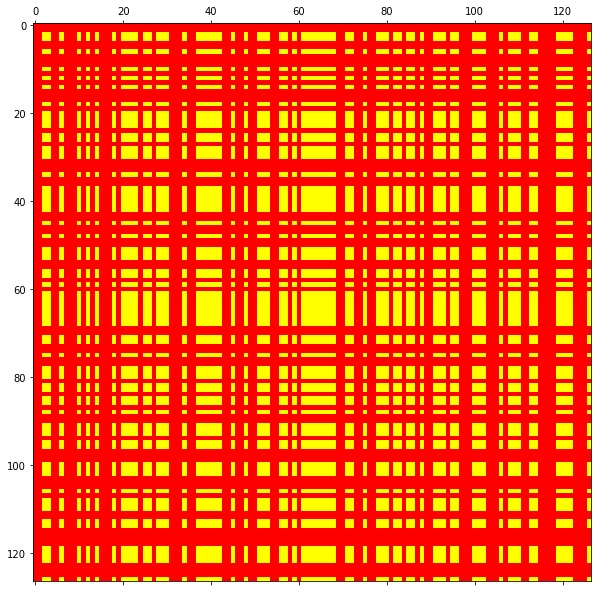

In [4]:
matrix = []
for index, row in articles_df.iterrows():
    
    temp_list = []
    
    if row['relevant_campbell'] == 1:
        
        for index, row in articles_df.iterrows():
            
            if row['relevant_campbell'] == 1:
                
                temp_list.append(1)
            
            else:
                
                temp_list.append(0)
                
    else:
        
        temp_list = list(np.zeros(len(articles_df)))
        
    
    matrix.append(temp_list)
    

plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(matrix, fignum=1)

plt.show()

In [5]:
start = time()

model = gensim.models.KeyedVectors.load_word2vec_format('wmd/GoogleNews-vectors-negative300.bin.gz', binary=True)
print('Cell took %.2f seconds to run.' % (time() - start))



Cell took 93.63 seconds to run.
Cell took 0.18 seconds to run.
1/32400


TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [6]:
def process_wmd_similarity(base_document, documents):
    base_document = preprocess(base_document)
    documents = preprocess(documents[0])
    
    distance = model.wmdistance(base_document, documents)
    
    try: 
        score = 1 / distance
    except:
        score = 0
    
    return score

articles = list(articles_df['text'])
temp_matrix = []

max_similarity = 0
min_similarity = 1000

count = 0
for index, row in articles_df.iterrows():
    
    temp_list = []
    
    for article_other in articles:
        
        start = time()
        similarity = process_wmd_similarity(row['text'], [article_other])
        print('Cell took %.2f seconds to run.' % (time() - start))
        count += 1
        print(str(count)+"/32400")
        #if similarity > 0.95:
        #    similarity = 0
        
        if similarity > max_similarity:
            max_similarity = similarity
            
        if similarity < min_similarity:
            min_similarity = similarity 
        
            
        temp_list.append(similarity)
                
    
    temp_matrix.append(temp_list)
    
print("Max similarity: " +str(max_similarity))

wmd_matrix = []

for temp_list in temp_matrix:
    
    normalized_list = []
    
    for similarity_value in temp_list:
        
        normalized_similarity = similarity_value / max_similarity
        normalized_list.append(normalized_similarity)
    
    wmd_matrix.append(normalized_list)

plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(wmd_matrix, fignum=1)

plt.show()

Cell took 0.19 seconds to run.
1/32400
Cell took 1.04 seconds to run.
2/32400
Cell took 0.79 seconds to run.
3/32400
Cell took 0.81 seconds to run.
4/32400
Cell took 0.90 seconds to run.
5/32400
Cell took 0.84 seconds to run.
6/32400
Cell took 0.96 seconds to run.
7/32400
Cell took 0.96 seconds to run.
8/32400
Cell took 0.86 seconds to run.
9/32400
Cell took 0.64 seconds to run.
10/32400
Cell took 1.00 seconds to run.
11/32400
Cell took 1.06 seconds to run.
12/32400
Cell took 0.81 seconds to run.
13/32400
Cell took 0.85 seconds to run.
14/32400
Cell took 0.98 seconds to run.
15/32400
Cell took 0.87 seconds to run.
16/32400
Cell took 0.70 seconds to run.
17/32400
Cell took 0.83 seconds to run.
18/32400
Cell took 0.84 seconds to run.
19/32400
Cell took 0.79 seconds to run.
20/32400
Cell took 0.78 seconds to run.
21/32400
Cell took 0.99 seconds to run.
22/32400
Cell took 0.75 seconds to run.
23/32400
Cell took 0.81 seconds to run.
24/32400
Cell took 0.84 seconds to run.
25/32400
Cell took

KeyboardInterrupt: 

In [ ]:
wmd_matrix = []
for i in range(len(matrix)):
    
    temp_list = []
    for j in range(len(matrix[i])):
        temp_list.append(matrix[i][j] - wmd_matrix[i][j])
    
    wmd_matrix.append(temp_list)
    
plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(wmd_matrix, fignum=1)

plt.show()

Cell took 0.02 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.01 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.01 seconds to run.
Cell took 0.01 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.02 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.01 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.01 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.02 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.01 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.01 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.01 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.01 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell took 0.00 seconds to run.
Cell too

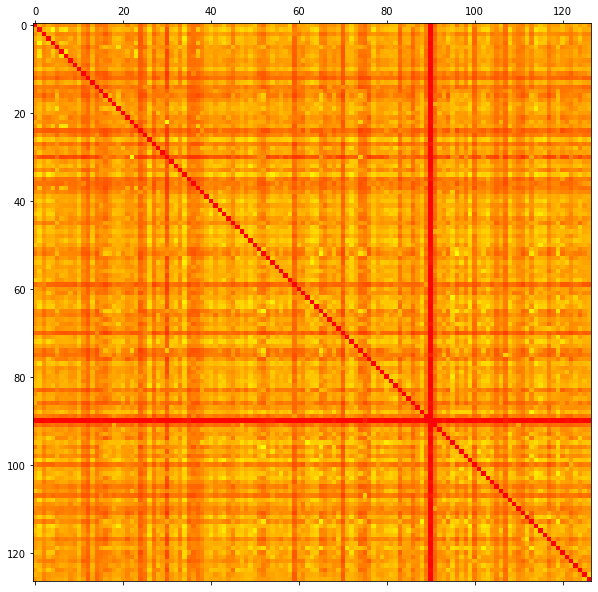

In [5]:
# TF-IDF SIMILARITY
def process_tfidf_similarity(base_document, documents):
    vectorizer = TfidfVectorizer()

    # To make uniformed vectors, both documents need to be combined first.
    documents.insert(0, base_document)
    embeddings = vectorizer.fit_transform(documents)

    cosine_similarities = cosine_similarity(embeddings[0:1], embeddings[1:]).flatten()

    highest_score = 0
    highest_score_index = 0
    for i, score in enumerate(cosine_similarities):
        if highest_score < score:
            highest_score = score
            highest_score_index = i


    most_similar_document = documents[highest_score_index]

    #print("Most similar document by TF-IDF with the score:", highest_score)
    return highest_score

articles = list(articles_df['text'])

temp_matrix = []


max_similarity = 0
min_similarity = 1

for index, row in articles_df.iterrows():
    
    temp_list = []
    
    for article_other in articles:
        
        start = time()
        
        similarity = process_tfidf_similarity(row['text'], [article_other])
        
        print('Cell took %.2f seconds to run.' % (time() - start))
        
        if similarity > 0.95:
            similarity = 0
        
        if similarity > max_similarity:
            max_similarity = similarity
            
        if similarity < min_similarity:
            min_similarity = similarity 
        
            
        temp_list.append(similarity)
                
    
    temp_matrix.append(temp_list)
    
print("Max similarity: " +str(max_similarity))

tf_idf_matrix = []

for temp_list in temp_matrix:
    
    normalized_list = []
    
    for similarity_value in temp_list:
        
        normalized_similarity = similarity_value / max_similarity
        normalized_list.append(normalized_similarity)
    
    tf_idf_matrix.append(normalized_list)

plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(tf_idf_matrix, fignum=1)

plt.show()

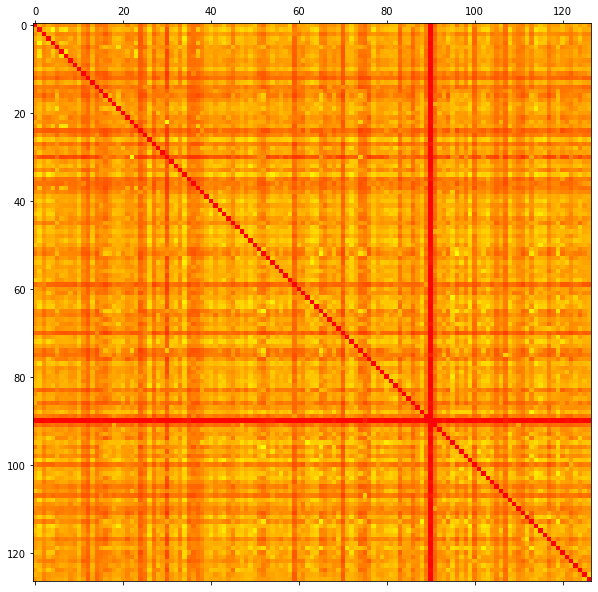

In [7]:
plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(tf_idf_matrix, fignum=1)

plt.show()

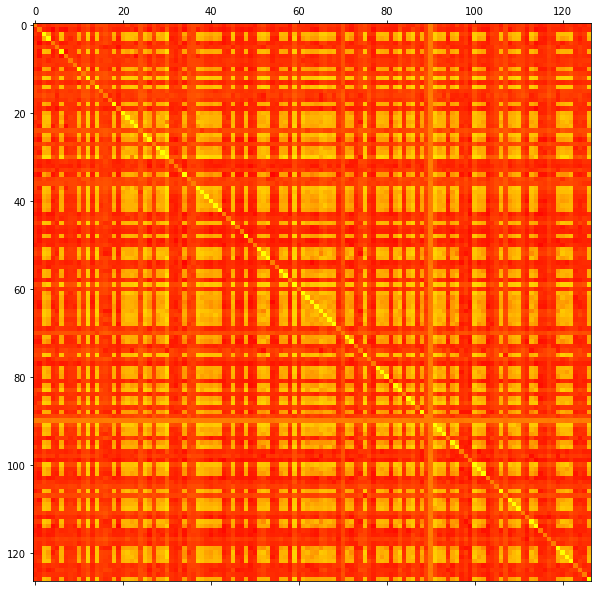

In [6]:
tf_idf_diff_matrix = []
for i in range(len(matrix)):
    
    temp_list = []
    for j in range(len(matrix[i])):
        temp_list.append(matrix[i][j] - tf_idf_matrix[i][j])
    
    tf_idf_diff_matrix.append(temp_list)
    
plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(tf_idf_diff_matrix, fignum=1)

plt.show()

Max similarity: 0.1661721068249258


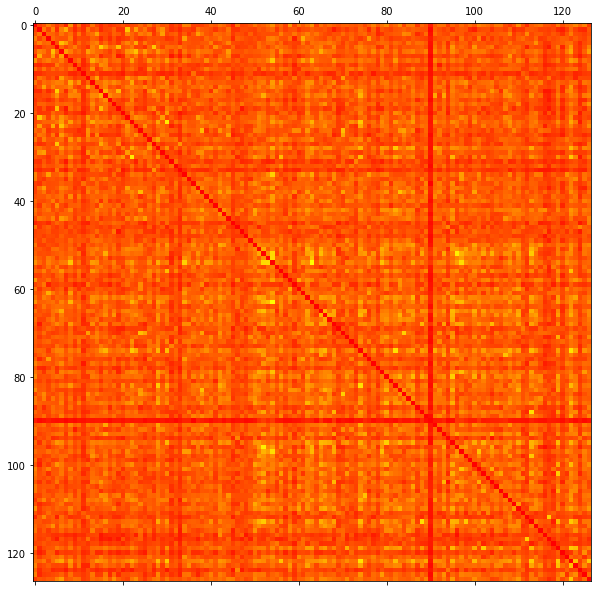

In [34]:
# JACCARD SIMILARITY 

def preprocess(text):
    # Steps:
    # 1. lowercase
    # 2. Lammetize. (It does not stem. Try to preserve structure not to overwrap with potential acronym).
    # 3. Remove stop words.
    # 4. Remove punctuations.
    # 5. Remove character with the length size of 1.

    lowered = str.lower(text)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(lowered)

    words = []
    for w in word_tokens:
        if w not in stop_words:
            if w not in string.punctuation:
                if len(w) > 1:
                    lemmatized = lemmatizer.lemmatize(w)
                    words.append(lemmatized)

    return words

def calculate_jaccard(word_tokens1, word_tokens2):
    # Combine both tokens to find union.
    both_tokens = word_tokens1 + word_tokens2
    union = set(both_tokens)

    # Calculate intersection.
    intersection = set()
    for w in word_tokens1:
        if w in word_tokens2:
            intersection.add(w)

    jaccard_score = len(intersection)/len(union)
    return jaccard_score

def process_jaccard_similarity(base_document, documents):

    # Tokenize the base document we are comparing against.
    base_tokens = preprocess(base_document)

    # Tokenize each document
    all_tokens = []
    for i, document in enumerate(documents):
        tokens = preprocess(document)
        all_tokens.append(tokens)

        #print("making word tokens at index:", i)

    all_scores = []
    for tokens in all_tokens:
        score = calculate_jaccard(base_tokens, tokens)

        all_scores.append(score)

    highest_score = 0
    highest_score_index = 0
    for i, score in enumerate(all_scores):
        if highest_score < score:
            highest_score = score
            highest_score_index = i

    most_similar_document = documents[highest_score_index]

    #print("Most similar document by Jaccard with the score:", most_similar_document, highest_score)
    return highest_score


articles = list(articles_df['text'])

temp_matrix = []


max_similarity = 0
min_similarity = 1

for index, row in articles_df.iterrows():
    
    temp_list = []
    
    for article_other in articles:
        
        
        similarity = process_jaccard_similarity(row['text'], [article_other])
        if similarity > 0.95:
            similarity = 0
        
        if similarity > max_similarity:
            max_similarity = similarity
            
        if similarity < min_similarity:
            min_similarity = similarity 
            
        temp_list.append(similarity)
                
    
    temp_matrix.append(temp_list)
    
print("Max similarity: " +str(max_similarity))

jaccard_matrix = []

for temp_list in temp_matrix:
    
    normalized_list = []
    
    for similarity_value in temp_list:
        
        normalized_similarity = similarity_value / max_similarity
        normalized_list.append(normalized_similarity)
    
    jaccard_matrix.append(normalized_list)

plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(jaccard_matrix, fignum=1)

plt.show()

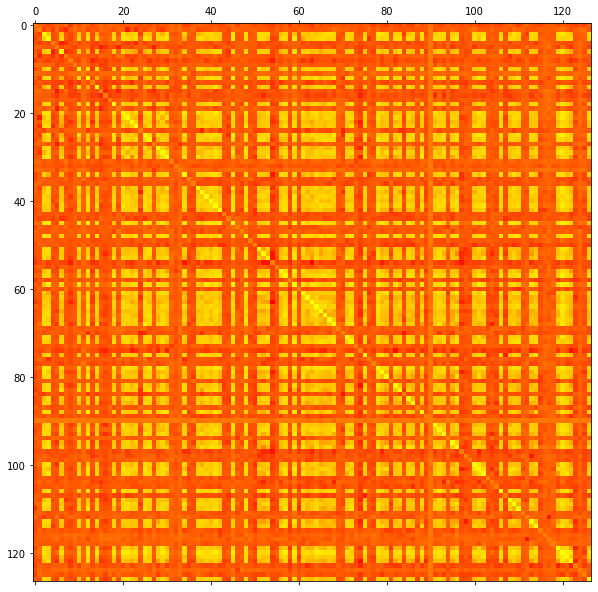

In [35]:
jaccard_diff_matrix = []
for i in range(len(matrix)):
    
    temp_list = []
    for j in range(len(matrix[i])):
        temp_list.append(matrix[i][j] - jaccard_matrix[i][j])
    
    jaccard_diff_matrix.append(temp_list)
    
plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(jaccard_diff_matrix, fignum=1)

plt.show()

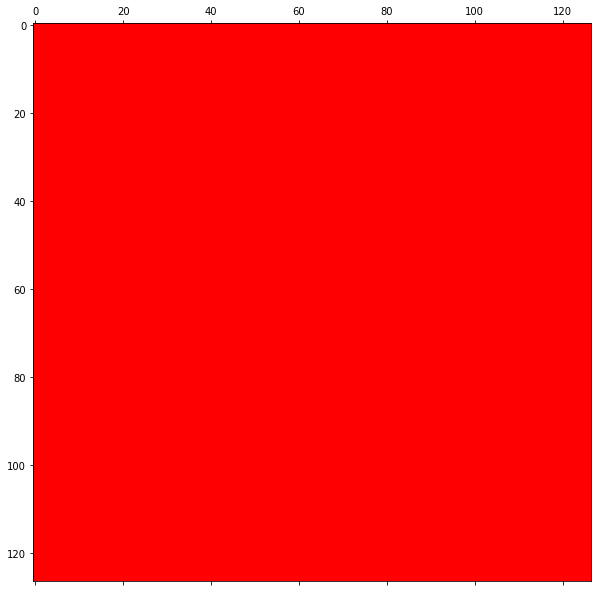

In [27]:
ref_diff_matrix = []
for i in range(len(matrix)):
    
    temp_list = []
    for j in range(len(matrix[i])):
        temp_list.append(matrix[i][j] - matrix[i][j])
    
    ref_diff_matrix.append(temp_list)
    
plt.figure(figsize = (10,10))
plt.set_cmap('autumn')

plt.matshow(ref_diff_matrix, fignum=1)

plt.show()

In [12]:
relevant_articles = list(articles_df[articles_df['relevant_campbell'] == 1]['text'])
irrelevant_articles = list(articles_df[articles_df['relevant_campbell'] == 0]['text'])

relevant_start_index = 1
irrelevant_start_index = 1

r_ir_start_index = 1
ir_r_start_index = 1

relevant_articles_affinity = []
irrelevant_articles_affinity = []

r_ir_articles_affinity = []
ir_r_articles_affinity = []

for index, row in articles_df.iterrows():
    if row['relevant_campbell'] == 1:
        for article_other in relevant_articles[relevant_start_index:]:
            relevant_articles_affinity.append(process_tfidf_similarity(row['text'], [article_other]))
        
        relevant_start_index += 1
        
        for article_other in irrelevant_articles[r_ir_start_index:]:
            r_ir_articles_affinity.append(process_tfidf_similarity(row['text'], [article_other]))
            
        r_ir_start_index += 1
    
    if row['relevant_campbell'] == 0:
        for article_other in irrelevant_articles[irrelevant_start_index:]:
            irrelevant_articles_affinity.append(process_tfidf_similarity(row['text'], [article_other]))
        
        irrelevant_start_index += 1
        
        for article_other in relevant_articles[ir_r_start_index:]:
            ir_r_articles_affinity.append(process_tfidf_similarity(row['text'], [article_other]))
        
        ir_r_start_index += 1
        
print(mean(relevant_articles_affinity))
print(mean(irrelevant_articles_affinity))
print(mean(r_ir_articles_affinity))
print(mean(ir_r_articles_affinity))

0.40954278535449873
0.3901359447902988


0.39050226771985197
0.3983421601903776


0.3901359447902988

In [15]:
# JACCARD SIMILARITY 

def preprocess(text):
    # Steps:
    # 1. lowercase
    # 2. Lammetize. (It does not stem. Try to preserve structure not to overwrap with potential acronym).
    # 3. Remove stop words.
    # 4. Remove punctuations.
    # 5. Remove character with the length size of 1.

    lowered = str.lower(text)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(lowered)

    words = []
    for w in word_tokens:
        if w not in stop_words:
            if w not in string.punctuation:
                if len(w) > 1:
                    lemmatized = lemmatizer.lemmatize(w)
                    words.append(lemmatized)

    return words

def calculate_jaccard(word_tokens1, word_tokens2):
    # Combine both tokens to find union.
    both_tokens = word_tokens1 + word_tokens2
    union = set(both_tokens)

    # Calculate intersection.
    intersection = set()
    for w in word_tokens1:
        if w in word_tokens2:
            intersection.add(w)

    jaccard_score = len(intersection)/len(union)
    return jaccard_score

def process_jaccard_similarity(base_document, documents):

    # Tokenize the base document we are comparing against.
    base_tokens = preprocess(base_document)

    # Tokenize each document
    all_tokens = []
    for i, document in enumerate(documents):
        tokens = preprocess(document)
        all_tokens.append(tokens)

        #print("making word tokens at index:", i)

    all_scores = []
    for tokens in all_tokens:
        score = calculate_jaccard(base_tokens, tokens)

        all_scores.append(score)

    highest_score = 0
    highest_score_index = 0
    for i, score in enumerate(all_scores):
        if highest_score < score:
            highest_score = score
            highest_score_index = i

    most_similar_document = documents[highest_score_index]

    #print("Most similar document by Jaccard with the score:", most_similar_document, highest_score)
    return highest_score




In [16]:
relevant_articles = list(articles_df[articles_df['relevant_campbell'] == 1]['text'])
irrelevant_articles = list(articles_df[articles_df['relevant_campbell'] == 0]['text'])

relevant_start_index = 1
irrelevant_start_index = 1

r_ir_start_index = 1
ir_r_start_index = 1

relevant_articles_affinity = []
irrelevant_articles_affinity = []

r_ir_articles_affinity = []
ir_r_articles_affinity = []

for index, row in articles_df.iterrows():
    if row['relevant_campbell'] == 1:
        for article_other in relevant_articles[relevant_start_index:]:
            relevant_articles_affinity.append(process_jaccard_similarity(row['text'], [article_other]))
        
        relevant_start_index += 1
        
        for article_other in irrelevant_articles[r_ir_start_index:]:
            r_ir_articles_affinity.append(process_jaccard_similarity(row['text'], [article_other]))
            
        r_ir_start_index += 1
    
    if row['relevant_campbell'] == 0:
        for article_other in irrelevant_articles[irrelevant_start_index:]:
            irrelevant_articles_affinity.append(process_jaccard_similarity(row['text'], [article_other]))
        
        irrelevant_start_index += 1
        
        for article_other in relevant_articles[ir_r_start_index:]:
            ir_r_articles_affinity.append(process_jaccard_similarity(row['text'], [article_other]))
        
        ir_r_start_index += 1
        
print(mean(relevant_articles_affinity))
print(mean(irrelevant_articles_affinity))
print(mean(r_ir_articles_affinity))
print(mean(ir_r_articles_affinity))

0.06609223010093603
0.05123178971804069
0.05399881746458884
0.05731987593736852


In [38]:
def process_bert_similarity(base_document, documents):
    # This will download and load the pretrained model offered by UKPLab.
    model = SentenceTransformer('bert-base-nli-mean-tokens')

    # Although it is not explicitly stated in the official document of sentence transformer, the original BERT is meant for a shorter sentence. We will feed the model by sentences instead of the whole documents.
    sentences = sent_tokenize(base_document)
    base_embeddings_sentences = model.encode(sentences)
    base_embeddings = np.mean(np.array(base_embeddings_sentences), axis=0)

    vectors = []
    for i, document in enumerate(documents):

        sentences = sent_tokenize(document)
        embeddings_sentences = model.encode(sentences)
        embeddings = np.mean(np.array(embeddings_sentences), axis=0)

        vectors.append(embeddings)

        #print("making vector at index:", i)

    scores = cosine_similarity([base_embeddings], vectors).flatten()

    highest_score = 0
    highest_score_index = 0
    for i, score in enumerate(scores):
        if highest_score < score:
            highest_score = score
            highest_score_index = i

    most_similar_document = documents[highest_score_index]
    #print("Most similar document by BERT with the score:", most_similar_document, highest_score)
    return highest_score




In [37]:
relevant_articles = list(articles_df[articles_df['relevant_campbell'] == 1]['text'])
irrelevant_articles = list(articles_df[articles_df['relevant_campbell'] == 0]['text'])

relevant_start_index = 1
irrelevant_start_index = 1

relevant_articles_affinity = []
irrelevant_articles_affinity = []

for index, row in articles_df.iterrows():
    if row['relevant_campbell'] == 1:
        for article_other in relevant_articles[relevant_start_index:]:
            relevant_articles_affinity.append(process_bert_similarity(row['text'], [article_other]))
        
        relevant_start_index += 1
    
    if row['relevant_campbell'] == 0:
        for article_other in irrelevant_articles[irrelevant_start_index:]:
            irrelevant_articles_affinity.append(process_bert_similarity(row['text'], [article_other]))
        
        irrelevant_start_index += 1

print(mean(relevant_articles_affinity))
print(mean(irrelevant_articles_affinity))

making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vecto

making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vecto

making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vecto

making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vector at index: 0
making vecto

KeyboardInterrupt: 

In [6]:
def preprocess(text):
    # Steps:
    # 1. lowercase
    # 2. Lammetize. (It does not stem. Try to preserve structure not to overwrap with potential acronym).
    # 3. Remove stop words.
    # 4. Remove punctuations.
    # 5. Remove character with the length size of 1.

    lowered = str.lower(text)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(lowered)

    words = []
    for w in word_tokens:
        if w not in stop_words:
            if w not in string.punctuation:
                if len(w) > 1:
                    lemmatized = lemmatizer.lemmatize(w)
                    words.append(lemmatized)

    return words

def process_doc2vec_similarity(base_document, documents):

    # Both pretrained models are publicly available at public repo of jhlau.
    # URL: https://github.com/jhlau/doc2vec

    # filename = './models/apnews_dbow/doc2vec.bin'
    filename = './document_similarity_algorithms_experiments/doc2vec/models/enwiki_dbow/doc2vec.bin'

    model= Doc2Vec.load(filename)

    tokens = preprocess(base_document)

    # Only handle words that appear in the doc2vec pretrained vectors. enwiki_ebow model contains 669549 vocabulary size.
    tokens = list(filter(lambda x: x in model.wv.vocab.keys(), tokens))

    base_vector = model.infer_vector(tokens)

    vectors = []
    for i, document in enumerate(documents):

        tokens = preprocess(document)
        tokens = list(filter(lambda x: x in model.wv.vocab.keys(), tokens))
        vector = model.infer_vector(tokens)
        vectors.append(vector)

        #print("making vector at index:", i)

    scores = cosine_similarity([base_vector], vectors).flatten()

    highest_score = 0
    highest_score_index = 0
    for i, score in enumerate(scores):
        if highest_score < score:
            highest_score = score
            highest_score_index = i

    most_similar_document = documents[highest_score_index]
    #print("Most similar document by Doc2vec with the score:", most_similar_document, highest_score)
    
    return highest_score


    

In [7]:
relevant_articles = list(articles_df[articles_df['relevant_campbell'] == 1]['text'])
irrelevant_articles = list(articles_df[articles_df['relevant_campbell'] == 0]['text'])

relevant_start_index = 1
irrelevant_start_index = 1

relevant_articles_affinity = []
irrelevant_articles_affinity = []

count = 0
for index, row in articles_df.iterrows():
    if row['relevant_campbell'] == 1:
        for article_other in relevant_articles[relevant_start_index:]:
            relevant_articles_affinity.append(process_doc2vec_similarity(row['text'], [article_other]))
            count+=1 
        relevant_start_index += 1
    
    if row['relevant_campbell'] == 0:
        for article_other in irrelevant_articles[irrelevant_start_index:]:
            irrelevant_articles_affinity.append(process_doc2vec_similarity(row['text'], [article_other]))
            count+=1
        irrelevant_start_index += 1
    
    print(count)
print(mean(relevant_articles_affinity))
print(mean(irrelevant_articles_affinity))

57


KeyboardInterrupt: 

In [8]:
def process_use_similarity(base_document, documents):
    filename = "./document_similarity_algorithms_experiments/use/models/universal-sentence-encoder_4"
    

    model = hub.load(filename)

    base_embeddings = model([base_document])

    embeddings = model(documents)

    scores = cosine_similarity(base_embeddings, embeddings).flatten()

    highest_score = 0
    highest_score_index = 0
    for i, score in enumerate(scores):
        if highest_score < score:
            highest_score = score
            highest_score_index = i

    most_similar_document = documents[highest_score_index]
    #print("Most similar document by USE with the score:", most_similar_document, highest_score)
    
    return highest_score
    
relevant_articles = list(articles_df[articles_df['relevant_campbell'] == 1]['text'])
irrelevant_articles = list(articles_df[articles_df['relevant_campbell'] == 0]['text'])

relevant_start_index = 1
irrelevant_start_index = 1

relevant_articles_affinity = []
irrelevant_articles_affinity = []

count = 0
for index, row in articles_df.iterrows():
    
    
    if row['relevant_campbell'] == 1:
        for article_other in relevant_articles[relevant_start_index:]:
            start = time()
            relevant_articles_affinity.append(process_use_similarity(row['text'], [article_other]))
            count+=1 
            print('Comparison took %.2f seconds to run.' % (time() - start))
            
        relevant_start_index += 1
    
    if row['relevant_campbell'] == 0:
        for article_other in irrelevant_articles[irrelevant_start_index:]:
            start = time()
            irrelevant_articles_affinity.append(process_use_similarity(row['text'], [article_other]))
            count+=1
            print('Comparison took %.2f seconds to run.' % (time() - start))

        irrelevant_start_index += 1
    
    print(count)
print(mean(relevant_articles_affinity))
print(mean(irrelevant_articles_affinity))

ResourceExhaustedError: OOM when allocating tensor with shape[26667,320] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:RestoreV2]